<h1>Multivariate time series modelling</h1>

Import python packages that are used to solve tasks.

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from MDEWMA import MDEWMA
import seaborn as sn

<h2>Daily correlation forecast using EWMA</h2>

In [3]:
# -*- coding: utf-8 -*-
def MDEWMA(logReturns,lamb=0.96,covMatrix=0):
    '''
    input: logReturns for N number of stocks in time t-1,
           lamda=0.96 if nothing else specified
    altinput: covariance matrix for previous period
    output: NxN-covariance matrix for stocks in time t-1
    '''
    import numpy as np
    try:
        if covMatrix.any() != 0:
            covMatrix = (1-lamb) * np.matmul(logReturns.T, logReturns) + lamb*covMatrix
        else:
            covMatrix = (1-lamb)/(lamb*(1-lamb)) * lamb*np.matmul(logReturns.T, logReturns)
    except:
        if covMatrix != 0:
            covMatrix = (1-lamb) * np.matmul(logReturns.T, logReturns) * lamb*covMatrix
        else:
            covMatrix = (1-lamb)/(lamb*(1-lamb)) * lamb*np.matmul(logReturns.T, logReturns) 
    return covMatrix

In [4]:
def covToCorr (cov,i1,i2):
    corr = [cov[i1][i2]/((np.sqrt(cov[i1][i1])*np.sqrt(cov[i2][i2])))]
    return corr

In [5]:
## Import from csv
trainFiles = ['CAT2007_2016','JPM2007_2016','WMT2007_2016']
excFiles = ['CAT2017_2020','JPM2017_2020','WMT2017_2020']
stockTickers = ['CAT','JPM','WMT']

trainDFs = []
trainLogReturns = []
for i in range(len(trainFiles)):
    df = pd.read_csv(trainFiles[i] + '.csv')
    df['Date'] = pd.to_datetime(df.Date)
    df['LogReturn'] = np.log(df['Close']).diff()
    trainLogReturns.append(df['LogReturn'].dropna().to_numpy())
    trainDFs.append(df)

excDFs = []
excLogReturns = []
for i in range(len(trainFiles)):
    df = pd.read_csv(excFiles[i] + '.csv')
    df['Date'] = pd.to_datetime(df.Date)
    df['LogReturn'] = np.log(df['Close']).diff()
    excLogReturns.append(df['LogReturn'].dropna().to_numpy())
    excDFs.append(df)

## get an covariancematrix based on period 2007-2016
covMatrix = 0
for i in range(len(trainLogReturns[1])):
    logReturns = np.zeros((1,len(trainLogReturns)))
    for j in range(len(trainLogReturns)):
        logReturns[0][j] = trainLogReturns[j][i]
    covMatrix = MDEWMA(logReturns, covMatrix=covMatrix)

## get covariancematrix and correlation based on period 2017-2020
correlations = [[covToCorr(covMatrix,0,1)],[covToCorr(covMatrix,0,2)],[covToCorr(covMatrix,1,2)]]
for i in range(len(excLogReturns[1])):
    logReturns = np.zeros((1,len(excLogReturns)))
    for j in range(len(excLogReturns)):
        logReturns[0][j] = excLogReturns[j][i]
    covMatrix = MDEWMA(logReturns, covMatrix=covMatrix)
    correlations[0].append(covToCorr(covMatrix,0,1))
    correlations[1].append(covToCorr(covMatrix,0,2))
    correlations[2].append(covToCorr(covMatrix,1,2))

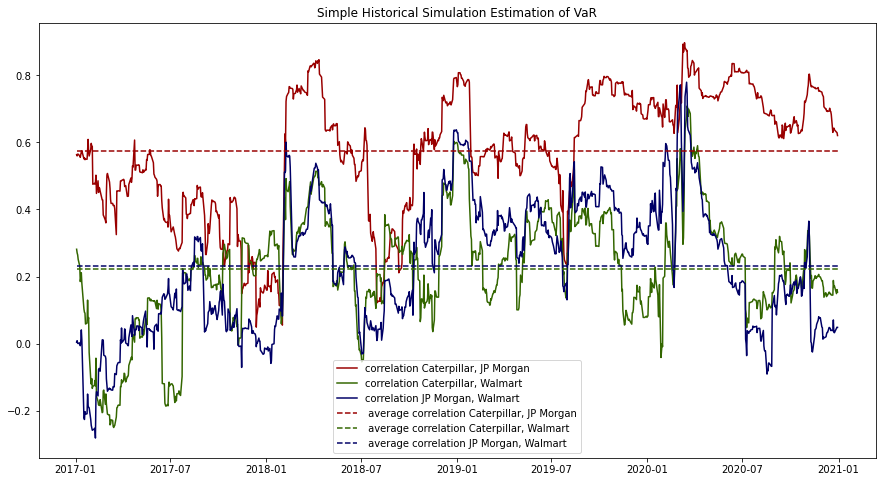

In [6]:
## Plot
plt.rcParams['figure.figsize'] = [12, 6]
y1 = np.mean(correlations[0])
y2 = np.mean(correlations[1])
y3 = np.mean(correlations[2])
lenght = np.ones(len(df['Date']))

red = mcolors.to_rgb('#990000')
green = mcolors.to_rgb('#336600')
blue = mcolors.to_rgb('#000066')


plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(df['Date'], correlations[0], label='correlation Caterpillar, JP Morgan',color=red)
plt.plot(df['Date'], correlations[1], label='correlation Caterpillar, Walmart',color=green)
plt.plot(df['Date'], correlations[2], label='correlation JP Morgan, Walmart',color=blue)
plt.plot(df['Date'], lenght*y1, ls='dashed', label=' average correlation Caterpillar, JP Morgan',color=red)
plt.plot(df['Date'], lenght*y2, ls='dashed', label=' average correlation Caterpillar, Walmart',color=green)
plt.plot(df['Date'], lenght*y3, ls='dashed', label=' average correlation JP Morgan, Walmart',color=blue)
plt.title('Simple Historical Simulation Estimation of VaR')
plt.legend(loc='best')
plt.show()

<h2>Explore the weekly data set (market_data.csv)</h2>
<h3>Performance/Evolution</h3>

In [7]:
## Import from csv
df = pd.read_csv('market_data.csv', sep=';', index_col='Date',parse_dates=True)

# log-returns
dfLogReturns = np.log(df).diff().dropna()

# Stocks
stockTickers = df.columns.tolist()[0:10]
dfRates = df.iloc[:, :10]
stockLR = dfLogReturns.iloc[:, :10]

# Interest Rates
iRates = df.columns.tolist()[10:]
dfRates = df.iloc[:, 10:]
iratesLR = dfLogReturns.iloc[:, 10:]

# VAR Parameters
marketTickers = df.columns.tolist()
logReturn = np.log(df).diff().dropna()[::-1]

M = np.log(df).diff().dropna()[::-1]
M.insert(0,'Ones',1)
M = M[1:].to_numpy()
LRt = logReturn[:-1].to_numpy()
Price = df.iloc[-1].to_list()

B = np.matmul(np.matmul(np.linalg.inv(np.matmul(M.T,M)),M.T),LRt)
A0 = B[0]
A1 = B[1:]

dfA1 = pd.DataFrame(A1, index=marketTickers, columns=marketTickers)
htmlA1 = dfA1.to_html()
Html_file= open("htmlA1.html","w")
Html_file.write(htmlA1)
Html_file.close()

In [8]:
# Normalize Stock prices t_0=100
hundreds = np.ones((len(stockTickers)))*100
normPerformence = np.zeros((len(hundreds),len(dfLogReturns)+1))
normPerformence[:,0] = hundreds

# transpose and numpying stock returns
stockLR_numpyT = stockLR.to_numpy().T

for t in range(len(normPerformence[0])-1):
    for stock in range(len(normPerformence)):
        normPerformence[stock,t+1] = normPerformence[stock,t]*(np.exp(stockLR_numpyT[stock,t]))


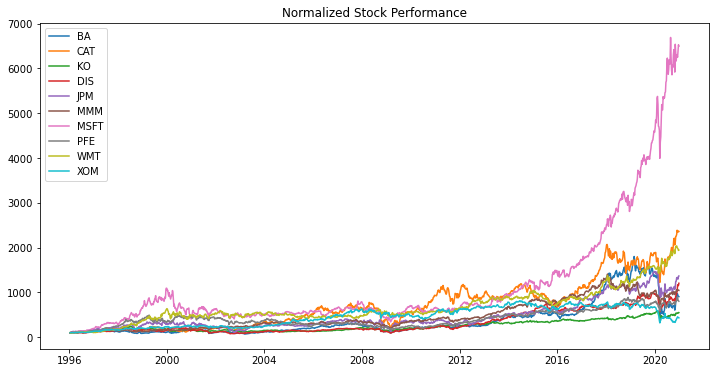

In [9]:
# Plot Stock Performance
plt.rcParams['figure.figsize'] = [12, 6]
for i in range(len(stockTickers)):
    plt.plot(df.index, normPerformence[i], label=stockTickers[i])
plt.title('Normalized Stock Performance')
plt.legend(loc='best')
plt.show()

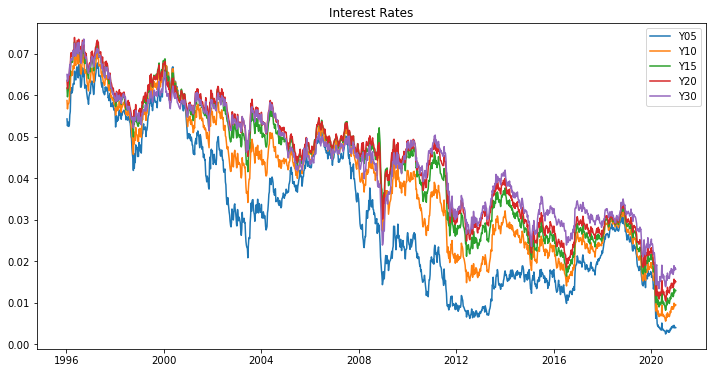

In [10]:
# Plot Stock Performance
for i in range(len(iRates)):
    plt.plot(df.index, dfRates.iloc[:,i], label=iRates[i])
plt.title('Interest Rates')
plt.legend(loc='best')
plt.show()

<h3>Key Figures</h3>

In [11]:
annualizedMeans = np.ones(15)
annualizedStd = np.ones(15)
lowquantile = np.ones(15)
highquantile = np.ones(15)
logMax = np.ones(15)
logMin = np.ones(15)
for stock in range(len(annualizedMeans)):
    annualizedMeans[stock] = np.mean(dfLogReturns.iloc[:,stock])*52
    annualizedStd[stock] = np.std(dfLogReturns.iloc[:,stock])*np.sqrt(52)
    lowquantile[stock] = np.quantile(dfLogReturns.iloc[:,stock], 0.05)
    highquantile[stock] = np.quantile(dfLogReturns.iloc[:,stock], 0.95)
    logMax[stock] = np.max(dfLogReturns.iloc[:,stock])
    logMin[stock] = np.min(dfLogReturns.iloc[:,stock])

| Instrument | Annualized mean Return |Annualized Volatility | 5th percentile | 95th percentile | Weekly High Return | Weekly Low Return |
| --- | --- | --- | --- | --- | --- |--- |
| Boeing | 0.08794262 |0.38185555 | -0.07060629 |0.07125424 |0.53361416 |-0.58299203 |
| Caterpillar |  0.12605552 | 0.3298415 | -0.07440842 |0.07618152 |  0.2692441 |-0.2249774 |
| Coca Cola |  0.06797631 |0.22910948 | -0.04594695 |0.04901501 |0.11150185 |-0.23645217 |
| Walt Disney |  0.09926226 | 0.2841437 | -0.05800812 |0.06402971 |  0.16332525 |-0.27727545 |
| JP Morgan |  0.10429534 | 0.3697546 |  -0.07644275 |0.0731607 |0.3993779  |-0.41684398|
| 3M | 0.09357438 |0.23353701 | -0.05343077 |0.05100948 |0.16022698 |-0.17442709|
| Microsoft |  0.16644705 |  0.29094519 | -0.06046052|0.0679904 |  0.20979852 |-0.2111514  |
| Pfizer | 0.08311797 |0.25618938 | -0.05187362  |0.05807489 |0.13306975  |-0.22709902 |
| Walmart | 0.11837569 |0.24522153 |-0.05295731 |0.05523324 | 0.16770168 |-0.16048776 |
| Exxon Mobile | 0.05845363 | 0.23108622 | -0.0503015 |0.05094659 | 0.15474757 |-0.22398281 |
| 5 Year Interest | -0.10450028 | 0.44049991 | -0.0905941 |0.10158156 | 0.41189083 |-0.39585229 |
| 10 Year Interest | -0.0729501 | 0.32566827 |  -0.06355593 |0.06904463 |  0.31986116 |-0.3676765 |
| 15 Year Interest | -0.06241375 | 0.2746492 | -0.05216253 |0.05540409 | 0.24397554  |-0.3166352 |
| 20 Year Interest | -0.0574536 | 0.24886153 | -0.04995222 |0.04995312 |0.19617268 |-0.27932813 |
| 30 Year Interest | -0.05106742 | 0.24118721 | -0.04982861 |0.04631698 |0.27301943 |-0.25082816 |


<h3>Correlation</h3>

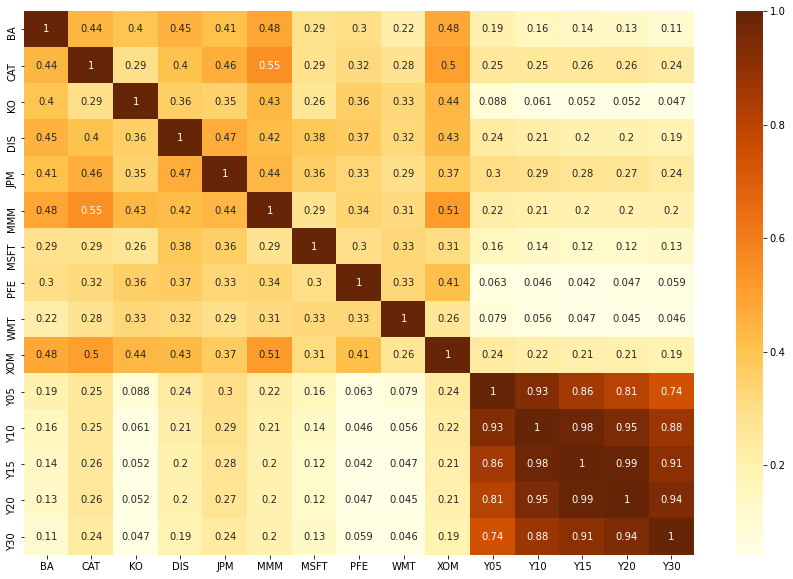

In [39]:
plt.rcParams['figure.figsize'] = [15, 10]
corrMatrix = dfLogReturns.corr()
sn.heatmap(corrMatrix, annot=True,cmap="YlOrBr")
plt.show()

<h2>VAR(1)-model</h2>
<h3>Estimate Parameters and Stability</h3>

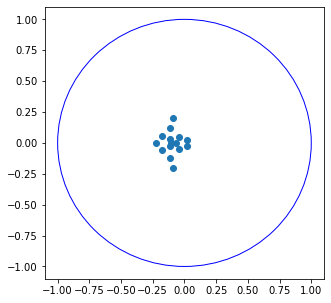

In [13]:
# Check Stability
e, v = np.linalg.eig(A1)
img = np.imag(e)
real = np.real(e)

plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
scatter = plt.scatter(real,img)
ax.add_patch(circ)
plt.show()

<h3>A0:</h3>

0.0019979805 , 0.0022077308 , 0.00147549 , 0.0018279129 , 0.0016635427 , 0.0020410315 , 0.0033824397 , 0.0016070871 , 0.0026921586 , 0.0012167469 , -0.0022300144 , -0.0015217827 , -0.0013180354 , -0.0012282106, -0.0010766345

<h3>A1:</h3>


TABLE HERE

<h3>volatilities of the VAR-residuals</h3>

In [ ]:
# Residuals
numpyLRt = dfLogReturns.to_numpy()
residuals = np.zeros((len(numpyLRt[0]),len(numpyLRt)-1))


for t in range(1,len(LRt)):
    residuals[:,t] = numpyLRt[t,:] - np.add(A0, np.matmul(A1.T, numpyLRt[t-1,:]))

residualCovariance = np.cov(residuals)
stdResiduals = np.sqrt(np.diag(residualCovariance))
C = np.linalg.cholesky(residualCovariance)

Residual Volatilities:

0.05109614, 0.04550019, 0.03103639, 0.03896875, 0.05017507, 0.03164047, 0.04006097, 0.03513032, 0.03301166, 0.03128286, 0.06037305, 0.04464219, 0.03771006, 0.03414101, 0.03291112

<h3>VAR Simulation</h3>

In [15]:
senarios = 2000 #iterations
steps = 480 #weekly
P0 = np.array(Price)

senarios_240 = np.zeros((len(LRt[0,:]),senarios))
senarios_480 = np.zeros((len(LRt[0,:]),senarios))

CAT = np.zeros((senarios,steps))
WMT = np.zeros((senarios,steps))
Y5 = np.zeros((senarios,steps))
Y30 = np.zeros((senarios,steps))


for s in range(senarios):
    #senario = np.zeros((steps,len(A0)))
    P = np.zeros((len(LRt[0,:]),steps+1))
    P[:,0] = P0
    #initilize return
    Y = np.zeros((len(LRt[0,:]),steps+1))
    Y[:,0] = LRt[0,:]

    for t in range(1,steps+1):
        Z = np.random.normal(0, 1, len(A0))
        Noice = np.matmul(C, Z)
        Y[:,t] = A0 + np.matmul(A1.T,Y[:,t-1]) + Noice
        for stock in range(len(P)):
            P[stock,t] = P[stock,t-1]*(np.exp(Y[stock,t-1]))
    
    senarios_240[:,s] = P[:,240]
    senarios_480[:,s] = P[:,480]

    CAT[s] = P[1,1:]
    WMT[s] = P[8,1:]
    Y5[s] = P[10,1:]
    Y30[s] = P[14,1:]


In [53]:
# VAR quantiles
strquantiles = ['5th Percentile','10th Percentile','25th Percentile','50th Percentile','75th Percentile','90th Percentile','95th Percentile']
quantiles = [0.05,.10,.25,.50,.75,.90,.95]

CATquantiles = np.zeros((steps, len(quantiles)))
WMTquantiles = np.zeros((steps, len(quantiles)))
Y5quantiles = np.zeros((steps, len(quantiles)))
Y30quantiles = np.zeros((steps, len(quantiles)))

for i in range(steps):
    for q in range(len(quantiles)):
        CATquantiles[i,q] = np.quantile(CAT[:,i],quantiles[q])
        WMTquantiles[i,q] = np.quantile(WMT[:,i],quantiles[q])
        Y5quantiles[i,q] = np.quantile(Y5[:,i],quantiles[q])
        Y30quantiles[i,q] = np.quantile(Y30[:,i],quantiles[q])

q240 = np.zeros((15,len(quantiles)))
q480 = np.zeros((15,len(quantiles)))

for s in range(15):
    i = 0
    for q in range(len(quantiles)):
        q240[s,i] = np.quantile(senarios_240[s],quantiles[q])
        q480[s,i] = np.quantile(senarios_480[s],quantiles[q])
        i += 1

dfq240 = pd.DataFrame(q240, index=marketTickers, columns=strquantiles)
htmlq240 = dfq240.to_html()
Html_file = open("htmlq240.html","w")
Html_file.write(htmlq240)
Html_file.close()

dfq480 = pd.DataFrame(q480, index=marketTickers, columns=strquantiles)
htmlq480 = dfq480.to_html()
Html_file = open("htmlq480.html","w")
Html_file.write(htmlq480)
Html_file.close()


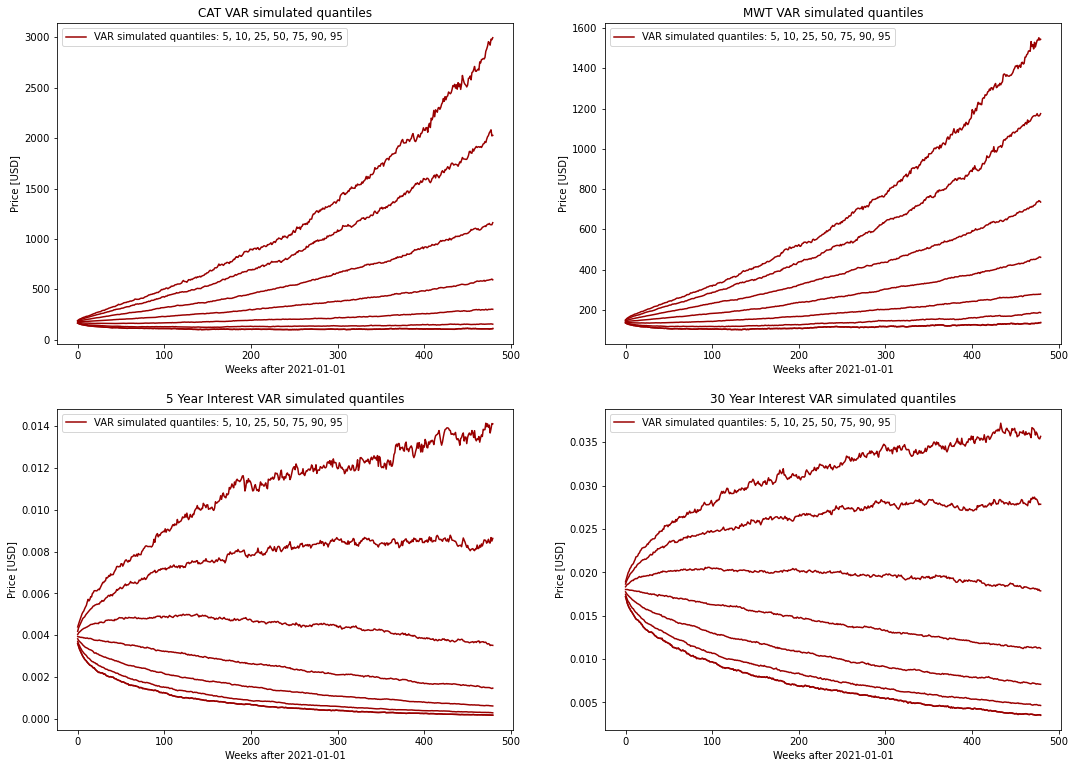

In [50]:
plt.rcParams['figure.figsize'] = [18,13]
red = mcolors.to_rgb('#990000')
x = np.arange(0,steps)
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(x,CATquantiles,color=red)
axs[0, 0].plot(x,CATquantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[0, 0].set_title('CAT VAR simulated quantiles')
axs[0, 0].set_ylabel('Price [USD]')
axs[0, 0].set_xlabel('Weeks after 2021-01-01')
axs[0, 0].legend(loc='upper left')


axs[0, 1].plot(x,WMTquantiles,color=red)
axs[0, 1].plot(x,WMTquantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[0, 1].set_title('MWT VAR simulated quantiles')
axs[0, 1].set_ylabel('Price [USD]')
axs[0, 1].set_xlabel('Weeks after 2021-01-01')
axs[0, 1].legend(loc='upper left')


axs[1, 0].plot(x,Y5quantiles,color=red)
axs[1, 0].plot(x,Y5quantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[1, 0].set_title('5 Year Interest VAR simulated quantiles')
axs[1, 0].set_ylabel('Price [USD]')
axs[1, 0].set_xlabel('Weeks after 2021-01-01')
axs[1, 0].legend(loc='upper left')


axs[1, 1].plot(x,Y30quantiles,color=red)
axs[1, 1].plot(x,Y30quantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[1, 1].set_title('30 Year Interest VAR simulated quantiles')
axs[1, 1].set_ylabel('Price [USD]')
axs[1, 1].set_xlabel('Weeks after 2021-01-01')
axs[1, 1].legend(loc='upper left')

<h2>Percentiles after 240 weeks:</h2>

<h2>Percentiles after 480 weeks:</h2>

TABLES HERE


<h2>Historical Simulation</h2>

In [58]:
senarios = 2000 #iterations
steps = 480 #weekly

CAT = np.zeros((senarios,steps))
WMT = np.zeros((senarios,steps))
Y5 = np.zeros((senarios,steps))
Y30 = np.zeros((senarios,steps))

for s in range(senarios):
    senario = np.zeros((steps,len(Price)))
    P = np.array(Price)
    for t in range(steps):
        Yt = LRt[np.random.randint(len(LRt))]
        for p in range(len(P)):
            P[p] = P[p]*np.exp(Yt[p])
        senario[t] = P

    senarios_240[:,s] = senario[239]
    senarios_480[:,s] = senario[479]

    CAT[s] = senario[:,1]
    WMT[s] = senario[:,8]
    Y5[s] = senario[:,10]
    Y30[s] = senario[:,14]


In [60]:
# HS HSquantiles
strquantiles = ['5th Percentile','10th Percentile','25th Percentile','50th Percentile','75th Percentile','90th Percentile','95th Percentile']
quantiles = [0.05,.10,.25,.50,.75,.90,.95]

CATHSquantiles = np.zeros((steps, len(quantiles)))
WMTHSquantiles = np.zeros((steps, len(quantiles)))
Y5HSquantiles = np.zeros((steps, len(quantiles)))
Y30HSquantiles = np.zeros((steps, len(quantiles)))

for i in range(steps):
    for q in range(len(quantiles)):
        CATHSquantiles[i,q] = np.quantile(CAT[:,i],quantiles[q])
        WMTHSquantiles[i,q] = np.quantile(WMT[:,i],quantiles[q])
        Y5HSquantiles[i,q] = np.quantile(Y5[:,i],quantiles[q])
        Y30HSquantiles[i,q] = np.quantile(Y30[:,i],quantiles[q])

q240 = np.zeros((15,len(quantiles)))
q480 = np.zeros((15,len(quantiles)))

for s in range(15):
    i = 0
    for q in range(len(quantiles)):
        q240[s,i] = np.quantile(senarios_240[s],quantiles[q])
        q480[s,i] = np.quantile(senarios_480[s],quantiles[q])
        i += 1

dfq240 = pd.DataFrame(q240, index=marketTickers, columns=strquantiles)
htmlq240 = dfq240.to_html()
Html_file = open("htmlq240HS.html","w")
Html_file.write(htmlq240)
Html_file.close()

dfq480 = pd.DataFrame(q480, index=marketTickers, columns=strquantiles)
htmlq480 = dfq480.to_html()
Html_file = open("htmlq480HS.html","w")
Html_file.write(htmlq480)
Html_file.close()


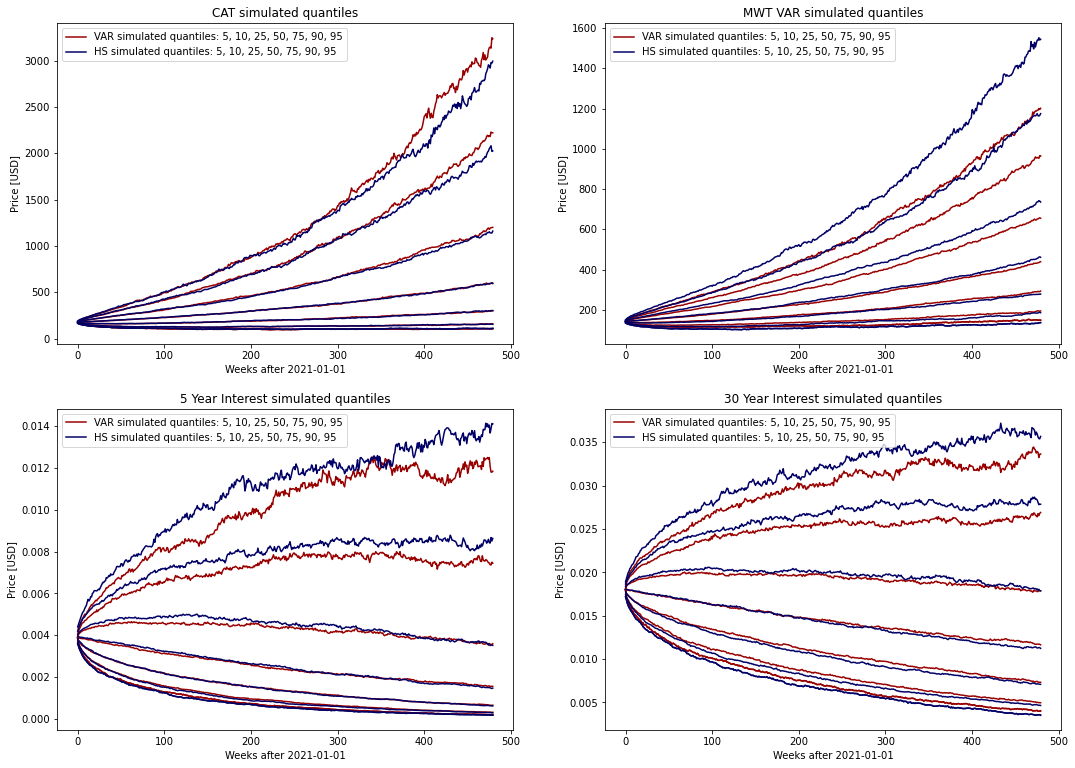

In [20]:
plt.rcParams['figure.figsize'] = [18,13]
red = mcolors.to_rgb('#990000')
blue = mcolors.to_rgb('#000066')
x = np.arange(0,steps)
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(x,CATquantiles,color=red)
axs[0, 0].plot(x,CATquantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[0, 0].plot(x,CATHSquantiles,color=blue)
axs[0, 0].plot(x,CATHSquantiles[:,0],color=blue, label='HS simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[0, 0].set_title('CAT simulated quantiles')
axs[0, 0].set_ylabel('Price [USD]')
axs[0, 0].set_xlabel('Weeks after 2021-01-01')
axs[0, 0].legend(loc='upper left')


axs[0, 1].plot(x,WMTquantiles,color=red)
axs[0, 1].plot(x,WMTquantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[0, 1].plot(x,WMTHSquantiles,color=blue)
axs[0, 1].plot(x,WMTHSquantiles[:,0],color=blue, label='HS simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[0, 1].set_title('MWT VAR simulated quantiles')
axs[0, 1].set_ylabel('Price [USD]')
axs[0, 1].set_xlabel('Weeks after 2021-01-01')
axs[0, 1].legend(loc='upper left')


axs[1, 0].plot(x,Y5quantiles,color=red)
axs[1, 0].plot(x,Y5quantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[1, 0].plot(x,Y5HSquantiles,color=blue)
axs[1, 0].plot(x,Y5HSquantiles[:,0],color=blue, label='HS simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[1, 0].set_title('5 Year Interest simulated quantiles')
axs[1, 0].set_ylabel('Price [USD]')
axs[1, 0].set_xlabel('Weeks after 2021-01-01')
axs[1, 0].legend(loc='upper left')


axs[1, 1].plot(x,Y30quantiles,color=red)
axs[1, 1].plot(x,Y30quantiles[:,0],color=red, label='VAR simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[1, 1].plot(x,Y30HSquantiles,color=blue)
axs[1, 1].plot(x,Y30HSquantiles[:,0],color=blue, label='HS simulated quantiles: 5, 10, 25, 50, 75, 90, 95')
axs[1, 1].set_title('30 Year Interest simulated quantiles')
axs[1, 1].set_ylabel('Price [USD]')
axs[1, 1].set_xlabel('Weeks after 2021-01-01')
axs[1, 1].legend(loc='upper left')

<h2>Percentiles after 240 weeks:</h2>

<h2>Percentiles after 480 weeks:</h2>

TABLES HERE
